# Quora Quesiton Pairs

[Competition Homepage](https://www.kaggle.com/c/quora-question-pairs)

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

For each ID in the test set, Kagglers must predict the probability that the questions are duplicates (a number between 0 and 1).  Submissions are evaluated on the log loss between the predicted values and the ground truth.

## Imports

In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
import datetime as dt
import math
import os
import gc
#import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline


from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

## EDA

### Raw Data Analysis

In [2]:
for f in os.listdir('./data.gi'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('./data.gi/' + f) / 1000000, 2)) + ' MB')

.ipynb_checkpoints            0.0 MB
test.csv                      314.02 MB
train.csv                     63.4 MB


The competition provides 3 .csv files - training set, testing set, and sample submission.  It is interesting to note that the testing set is approximately 5x the size of the training set.  The [Data](https://www.kaggle.com/c/quora-question-pairs/data) section of the competition homepage states the following: 

*"As an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora."*

The sample submission file can be ignored as it is just an example for Kagglers to follow when preparing their .csv files for submission.

### Training Set Analysis

**Train Columns:**
- **id:** (int) question pair identifier
- **qid1:** (int) single question identifer (first in pair)
- **qid2:** (int) single question identfier (second in pair)
- **question1:** (string) first question text
- **question2:** (string) second question text
- **is_duplicate:** (int) binary duplicate indicator - this is our label for supervised training

In [3]:
TRAIN = pd.read_csv('./data.gi/train.csv')
TRAIN.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
TRAIN.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


The last value in the *id* column matches the last row index value, indicating there are no jumps in ID.  The individual question IDs, however, do not appear to increase consistently.  Otherwise, we would expect *qid2* in row 404289 to be 808578.  Therefore, we will need to determine if the same questions are being used across pairs.

#### Duplicate Questions Across Pairs

Number of total questions:    537933
Number of unique questions:   426153
Number of repeated questions: 111780

Percent unique: 0.79%


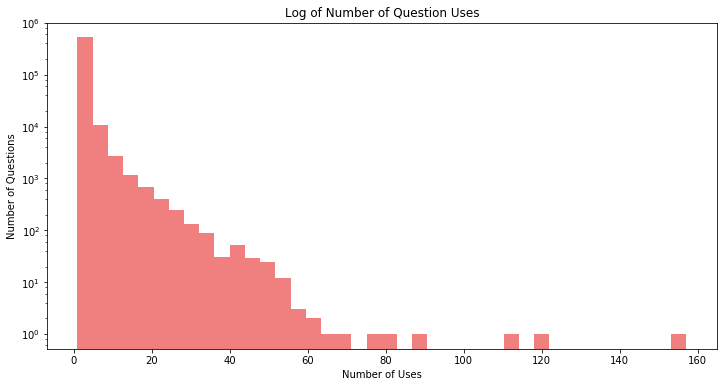

In [5]:
qid = TRAIN.qid1.tolist() + TRAIN.qid2.tolist()
qid_dict = dict.fromkeys(qid, 0)

for x in qid:
    qid_dict[x] += 1

unique = 0
for x in qid_dict:
    if qid_dict[x] == 1:
        unique += 1

total = len(qid_dict)
non_unique = total - unique

print('Number of total questions: '.ljust(30) + str(total))
print('Number of unique questions: '.ljust(30) + str(unique))
print('Number of repeated questions: '.ljust(30) + str(non_unique))
print('\nPercent unique: ' + '{0:.2f}%'.format(unique / total))

plt.figure(figsize=(12, 6))
plt.hist(pd.Series(qid).value_counts(), bins=40, log=True, color='lightcoral', label='train')
plt.xlabel('Number of Uses')
plt.ylabel('Number of Questions')
plt.title('Log of Number of Question Uses')
plt.show()

del qid, qid_dict, unique, total, non_unique

About 80% of questions are used only once, however, there are a number of quetions that are used many times.  There are also a few cases of outliers that are used 100+ times.

#### Class Imbalance of Pairs Labeled as Duplicate

Number of question pairs:     404290
Number of duplicates:         149263
Number of non-duplicates:     255027


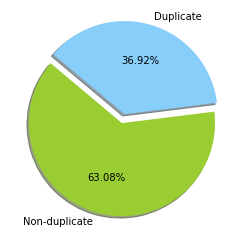

In [6]:
print('Number of question pairs: '.ljust(30) + str(len(TRAIN)))
print('Number of duplicates: '.ljust(30) + str(len(TRAIN[TRAIN.is_duplicate == 1])))
print('Number of non-duplicates: '.ljust(30) + str(len(TRAIN[TRAIN.is_duplicate == 0])))

plt.figure(figsize=(4, 4))
plt.pie(TRAIN.is_duplicate.value_counts(), explode=(0.1, 0), labels=('Non-duplicate', 'Duplicate'), colors=('yellowgreen', 'lightskyblue'), autopct='%1.2f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

There is about a 2:1 class imbalance in favor of non-duplicate question pairs.  As a result, it will make sense to evaluate models on roc auc along with the log loss metric.

### Test Set Analysis

**Test Columns:**
- **test_id:** (int) question pair identifier
- **question1:** (string) first question text
- **question2:** (string) second question text

In [7]:
TEST = pd.read_csv('./data.gi/test.csv')
TEST.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [8]:
TEST.tail()

,test_id,question1,question2
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...
2345795,2345795,What is the best medication equation erectile ...,How do I out get rid of Erectile Dysfunction?


There are no apparent incongruities in the *test_id* column as its final value matches the final index value.  Regarding computer-generated question pairs, test_id[4] appears to be an example with the two questions:
1. How "aberystwyth" start reading?
2. How their can I start reading?

It is also worthwhile pointing out that there is no straightforward way to determine if any questions are reused in the test set.

### Question Analysis

In [9]:
train_questions = TRAIN.question1.tolist() + TRAIN.question2.tolist()
test_questions = TEST.question1.tolist() + TEST.question2.tolist()

#### Missing Values

In [10]:
print('Train')
print('-----')
print('Question 1:'.ljust(30) + str(TRAIN.question1.isnull().sum()))
print('Question 2:'.ljust(30) + str(TRAIN.question2.isnull().sum()))
print('\nTest')
print('----')
print('Question 1:'.ljust(30) + str(TEST.question1.isnull().sum()))
print('Question 2:'.ljust(30) + str(TEST.question2.isnull().sum()))

Train
-----
Question 1:                   0
Question 2:                   2

Test
----
Question 1:                   2
Question 2:                   4


#### Word Count


Train Statistics
----------------
count    808580.000000
mean         11.064856
std           5.889168
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

Test Statistics
---------------
count    4.691592e+06
mean     1.102431e+01
std      5.839925e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      2.380000e+02
dtype: float64


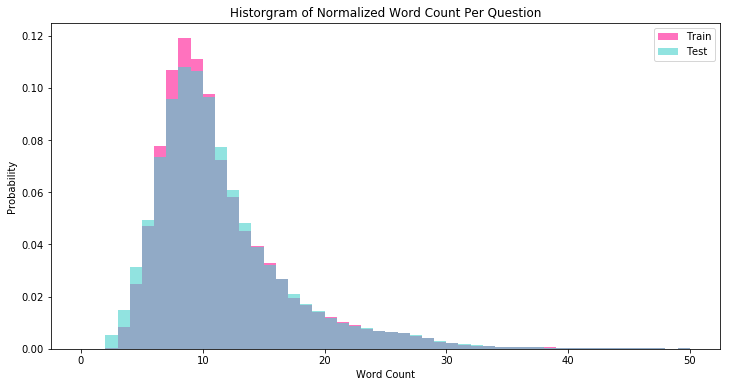

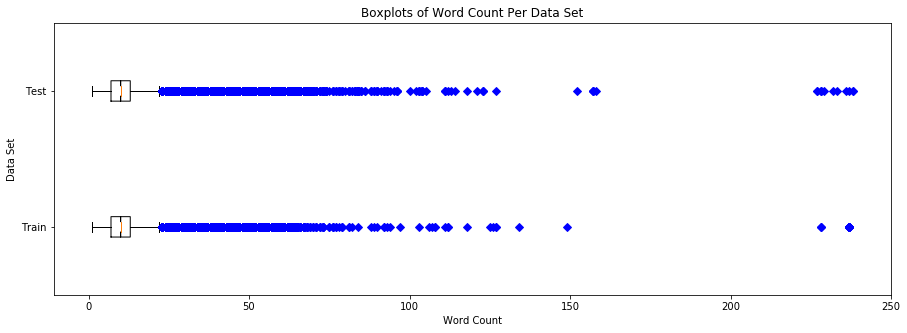

In [11]:
train_word_counts = pd.Series([len(str(x).split(' ')) for x in train_questions])
test_word_counts = pd.Series([len(str(x).split(' ')) for x in test_questions])

print('\nTrain Statistics')
print('----------------')
print(train_word_counts.describe())
print('\nTest Statistics')
print('---------------')
print(test_word_counts.describe())

plt.figure(figsize=(12,6))
plt.hist(train_word_counts, bins=50, range=[0, 50], color=('deeppink'), normed=True, alpha=0.6, label='Train')
plt.hist(test_word_counts, bins=50, range=[0, 50], color=('mediumturquoise'), normed=True, alpha=0.6, label='Test')
plt.xlabel('Word Count')
plt.ylabel('Probability')
plt.title('Historgram of Normalized Word Count Per Question')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([train_word_counts, test_word_counts], True, 'bD', vert=False, labels=('Train', 'Test'))
plt.xlabel('Word Count')
plt.ylabel('Data Set')
plt.title('Boxplots of Word Count Per Data Set')
plt.show()

#### Character Count


TRAIN Statistics:
-----------------
count    808580.000000
mean         59.822548
std          31.963751
min           1.000000
25%          39.000000
50%          51.000000
75%          72.000000
max        1169.000000
dtype: float64

TEST Statistics:
----------------
count    4.691592e+06
mean     6.007010e+01
std      3.162463e+01
min      1.000000e+00
25%      4.000000e+01
50%      5.300000e+01
75%      7.200000e+01
max      1.176000e+03
dtype: float64


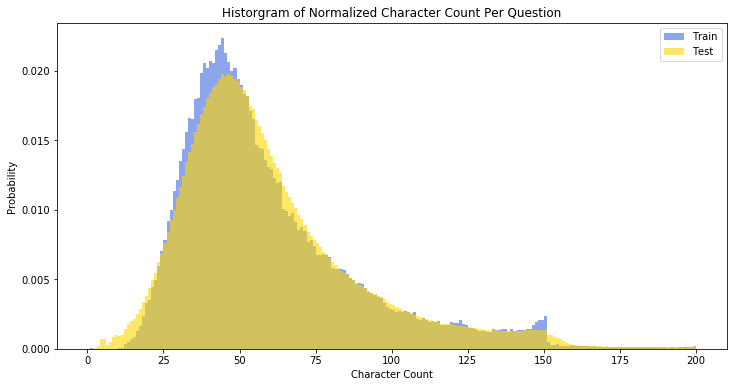

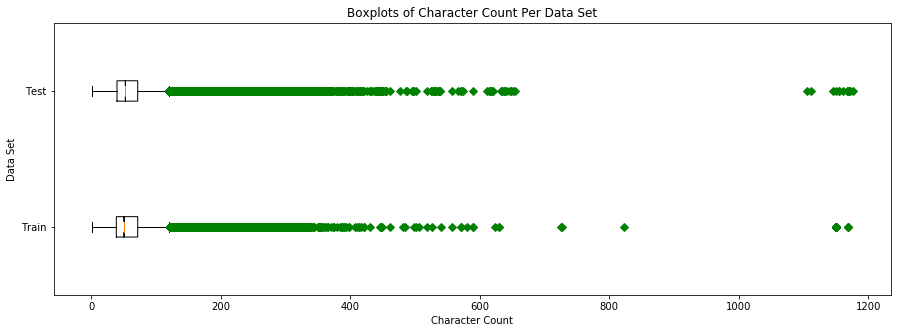

In [12]:
train_char_counts = pd.Series([len(str(x))for x in train_questions])
test_char_counts = pd.Series([len(str(x)) for x in test_questions])

print('\nTRAIN Statistics:')
print('-----------------')
print(train_char_counts.describe())
print('\nTEST Statistics:')
print('----------------')
print(test_char_counts.describe())

plt.figure(figsize=(12,6))
plt.hist(train_char_counts, bins=200, range=[0, 200], color=('royalblue'), normed=True, alpha=0.6, label='Train')
plt.hist(test_char_counts, bins=200, range=[0, 200], color=('gold'), normed=True, alpha=0.6, label='Test')
plt.xlabel('Character Count')
plt.ylabel('Probability')
plt.title('Historgram of Normalized Character Count Per Question')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.boxplot([train_char_counts, test_char_counts], True, 'gD', vert=False, labels=('Train', 'Test'))
plt.xlabel('Character Count')
plt.ylabel('Data Set')
plt.title('Boxplots of Character Count Per Data Set')
plt.show()

In [13]:
del train_questions, test_questions, train_word_counts, test_word_counts, train_char_counts, test_char_counts
gc.collect()

64529

### Feature Analysis

#### Text Preprocessing

In [14]:
def tokenize(q):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(q.lower())

#### Word Share

In [50]:
def calculate_word_share(p, stopset=[], stem=False, tfidf_weights={}):
    # tokenize
    q1_words = tokenize(p['question1']) if not pd.isnull(p['question1']) else []
    q2_words = tokenize(p['question2']) if not pd.isnull(p['question2']) else []
    # filter stopwords
    q1_filtered = [x for x in q1_words if x not in stopset]
    q2_filtered = [x for x in q2_words if x not in stopset]
    # stem
    if stem:
        stemmer = SnowballStemmer('english')
        q1_filtered = [stemmer.stem(x) for x in q1_filtered]
        q2_filtered = [stemmer.stem(x) for x in q2_filtered]
    # calculate word share
    if tfidf_weights:
        q1_shared = np.sum([tfidf_weights.get(x, 0) for x in q1_filtered if x in q2_filtered])
        q2_shared = np.sum([tfidf_weights.get(x, 0) for x in q2_filtered if x in q1_filtered])
        total = np.sum([tfidf_weights.get(x, 0) for x in q1_words]) + np.sum([tfidf_weights.get(x, 0) for x in q2_words])
    else:
        q1_shared = len([x for x in q1_filtered if x in q2_filtered])
        q2_shared = len([x for x in q2_filtered if x in q1_filtered])
        total = len(q1_filtered) + len(q2_filtered)
    if total == 0:
        return 0
    else:
        return (q1_shared + q2_shared) / total

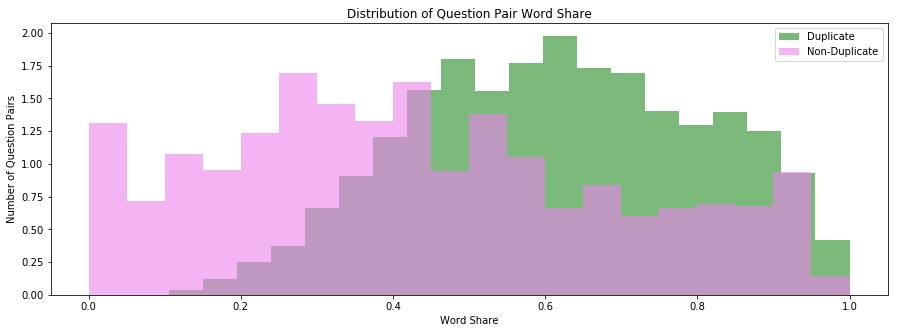

In [16]:
# Complete sentence
train_word_share = TRAIN.apply(calculate_word_share, axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_share[TRAIN.is_duplicate == 1], bins=20, color=('forestgreen'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(train_word_share[TRAIN.is_duplicate == 0], bins=20, color=('violet'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share')
plt.legend()
plt.show()

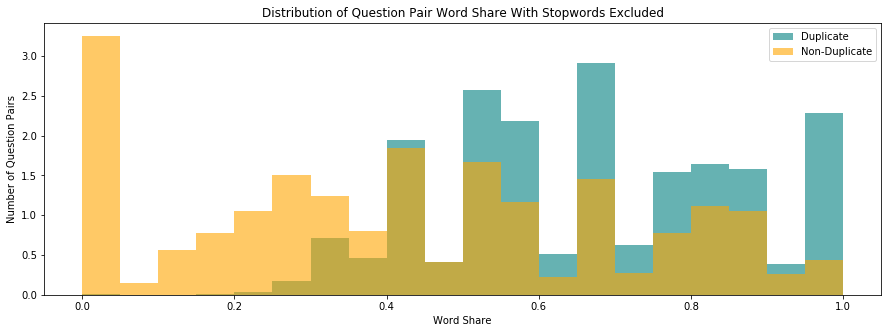

In [17]:
# Stopword filtering
train_word_share_no_stopwords = TRAIN.apply(lambda x: calculate_word_share(x, stopwords.words('english')), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_share_no_stopwords[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(train_word_share_no_stopwords[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share With Stopwords Excluded')
plt.legend()
plt.show()

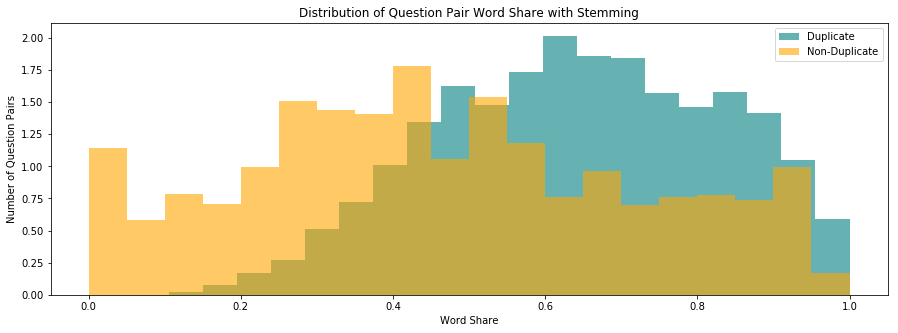

In [18]:
# Stemming
train_word_share_stemmed = TRAIN.apply(lambda x: calculate_word_share(x, stem=True), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_share_stemmed[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(train_word_share_stemmed[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stemming')
plt.legend()
plt.show()

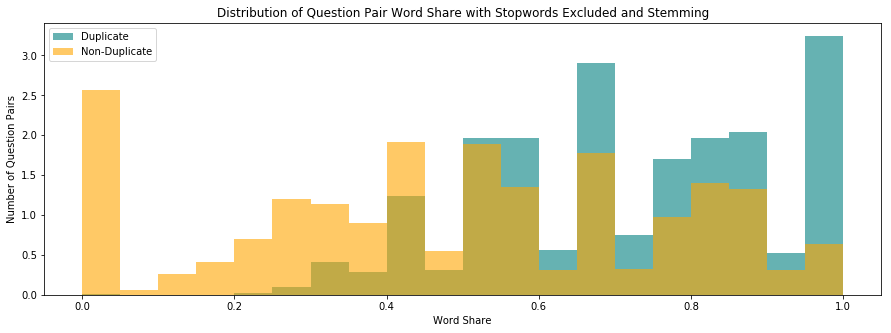

In [19]:
# Stopword filtering and stemming
train_word_share_no_stopwords_stemmed = TRAIN.apply(lambda x: calculate_word_share(x, stopwords.words('english'), True), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(train_word_share_no_stopwords_stemmed[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(train_word_share_no_stopwords_stemmed[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share with Stopwords Excluded and Stemming')
plt.legend()
plt.show()

#### TF-IDF

In [20]:
vectorizer = TfidfVectorizer()
TDX = vectorizer.fit_transform(TRAIN.question1.append(TRAIN.question2).fillna(''))

In [40]:
weights_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
weights_tuplst = list(zip(vectorizer.get_feature_names(), vectorizer.idf_))
weights_tuplst.sort(key=lambda x: x[1])

print('10 Most Frequent Terms')
print('----------------------')
print(weights_tuplst[:20])
print('\n10 Least Frequent Terms')
print('-----------------------')
print(weights_tuplst[len(weights_tuplst)-10:])

10 Most Frequent Terms
----------------------
[('what', 1.9399247964366455), ('the', 1.973746879295827), ('is', 2.149759724116616), ('how', 2.3162548532419418), ('to', 2.4976571376623244), ('in', 2.5052337935139097), ('do', 2.6520944807815461), ('of', 2.7251828782551408), ('are', 2.7516333056811715), ('and', 2.8923916025656324), ('can', 2.9445481955417416), ('for', 3.1081728163580009), ('why', 3.2905758345698364), ('you', 3.3221814542537937), ('best', 3.445415128456141), ('it', 3.507871059741908), ('my', 3.5673564640423874), ('on', 3.6336144596961653), ('does', 3.6847527833986935), ('which', 3.9261817903123295)]

10 Least Frequent Terms
-----------------------
[('鸡精', 13.909888957949875), ('黄雀在后', 13.909888957949875), ('黎权锋', 13.909888957949875), ('齐家', 13.909888957949875), ('니콜라스에게', 13.909888957949875), ('될까요', 13.909888957949875), ('북쪽앟관자키', 13.909888957949875), ('분위기', 13.909888957949875), ('불타오르네', 13.909888957949875), ('친구해도', 13.909888957949875)]


In [42]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        q1words[word] = 1
    for word in str(row['question2']).lower().split():
        q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights_dict.get(w, 0) for w in q1words.keys() if w in q2words] + [weights_dict.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights_dict.get(w, 0) for w in q1words] + [weights_dict.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

Start:  2017-05-08 13:12:01.608081


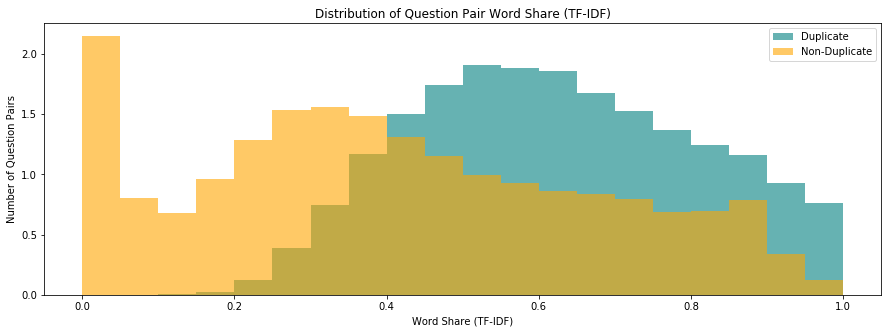

End:  2017-05-08 13:13:08.002720


In [51]:
print('Start: ', str(dt.datetime.now()))

tfidf_train_word_share = TRAIN.apply(lambda x: calculate_word_share(x, tfidf_weights=weights_dict), axis=1, raw=True)

plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_word_share[TRAIN.is_duplicate == 1], bins=20, color=('teal'), normed=True, alpha=0.6, label='Duplicate')
plt.hist(tfidf_train_word_share[TRAIN.is_duplicate == 0], bins=20, color=('orange'), normed=True, alpha=0.6, label='Non-Duplicate')
plt.xlabel('Word Share (TF-IDF)')
plt.ylabel('Number of Question Pairs')
plt.title('Distribution of Question Pair Word Share (TF-IDF)')
plt.legend()
plt.show()

print('End: ', str(dt.datetime.now()))

#### ROC AUC Comparison

In [59]:
print('Word Share Proportion')
print('---------------------')
print('Base:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, train_word_share))
print('Filtered:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, train_word_share_no_stopwords))
print('Stemmed:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, train_word_share_stemmed))
print('Filtered & Stemmed:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, train_word_share_no_stopwords_stemmed))
print('\nTF-IDF Weighting')
print('----------------')
print('Base:'.ljust(30), roc_auc_score(TRAIN.is_duplicate, tfidf_train_word_share))

Word Share Proportion
---------------------
Base:                          0.717529896461
Filtered:                      0.743939809911
Stemmed:                       0.713523771993
Filtered & Stemmed:            0.737908827868

TF-IDF Weighting
----------------
Base:                          0.740072083458
